We just had a fairly high-profile retraction in my field ([de Haas et al., 2014, Current Biology](https://doi.org/10.1016/j.cub.2020.11.015)). This is kind of unusual - cognitive neuroscience is one of those fields where researchers tend to fight hard rather than cede ground when someone points out a problem. I really admire the way the authors handled this. One of the authors wrote a [blog post](https://neuroneurotic.net/2020/10/29/when-the-hole-changes-the-pigeon/) expanding on what went wrong, which turns out to be more than one thing (they are working on a preprint with all the simulation work that the blog post alludes to). But the key issue is [regression to the mean](https://en.wikipedia.org/wiki/Regression_toward_the_mean), one of those nebulous concepts that often catches people out. This is actually such a beautiful example of it happening in real data that I thought it would be worth reproducing the artefact and thinking about how it could have been detected and avoided. You can access an [interactive version of this notebook on Google Collab](https://colab.research.google.com/drive/1lIIAWGObdMsxkBui1Ub2rR1zlUghcoDg?usp=sharing).

## The study
This is a fairly typical vision fMRI study. The authors present a bunch of visual stimuli under two attentional conditions. Then they fit a population receptive field (pRF) model to each voxel in their regions of interest. We don't need to go too deep on the details of the method, because it turns out not to matter. The key thing to appreciate is that the pRF fit produces an estimate of preferred *eccentricity* from each voxel, that is, how far from the fovea does the voxel respond maximally, and the *size* of the receptive field, that is, how the response falls off as you stimulate visual-field positions away from this peak. The claims in the paper are all about how these pRF parameter estimates change when the attentional context changes.

We can run a simple simulation to reproduce the type of estimates the authors get for eccentricity. First, some imports and a plot function

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
%config InlineBackend.figure_format = 'retina'

def make_plot(x, y, x_binned=None, y_binned=None, binlabel='', highlight=None, metric='eccentricity'):
    fig, ax_scatter = plt.subplots(1, 1, figsize=[5, 5])
    # plot x against y, overlay the (circular) y bins
    ax_scatter.plot(x, y, '.', color=(.5,.5,.5), label='voxels')
    if np.any(x_binned):
        ax_scatter.plot(x_binned, y_binned, '-ok', label=binlabel)
    if np.any(highlight):
        ax_scatter.plot(x[highlight], y[highlight], 'or', label=f"index {highlight}")
    ax_scatter.set_xlabel(f'{metric} (x)')
    ax_scatter.set_ylabel(f'{metric} (y)')
    ax_scatter.legend()
    # squarify axes
    new_lim = [np.min(ax_scatter.axis()), np.max(ax_scatter.axis())]
    ax_scatter.plot(new_lim, new_lim, 'k', linewidth=.5)
    ax_scatter.set_aspect('equal')
    ax_scatter.set_xlim(new_lim)
    ax_scatter.set_ylim(new_lim)
    ticks = ax_scatter.get_yticks()
    ax_scatter.set_xticks(ticks)
    ax_scatter.set_yticks(ticks)

Now for the simulation. We simulate the null case here, so the two contexts are sampled from the same underlying distribution.

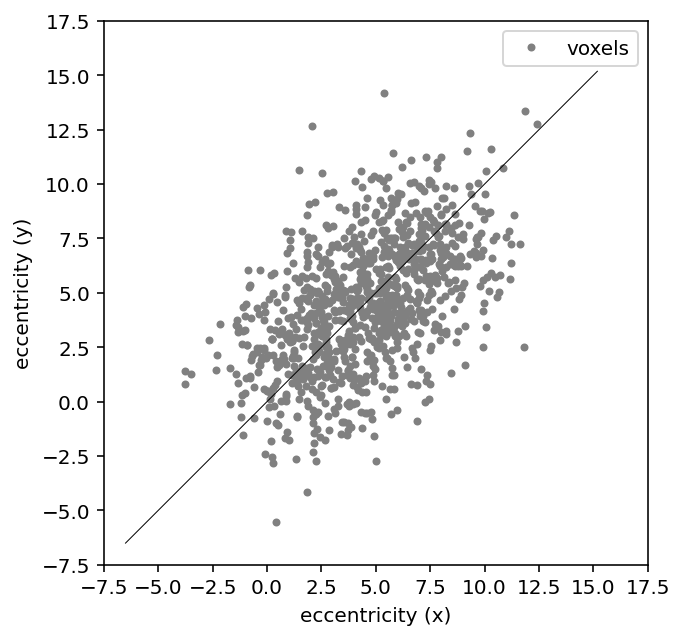

In [2]:
# simulate two attention contexts (x, y)
n_vox = 1000
noise_sigma = 2.
# shared ground-truth eccentricity component
min_ecc, max_ecc = (1., 8.)
base_ecc = np.linspace(min_ecc, max_ecc, n_vox)
# independent noise on the two estimates
ecc_x = base_ecc + noise_sigma * np.random.randn(n_vox)
# you could add an offset here to simulate H1
ecc_y = base_ecc + noise_sigma * np.random.randn(n_vox)
make_plot(ecc_x, ecc_y)

Overall there is a decent relationship between the eccentricity estimate from context x and y, but there is also a fair bit of noise. What we're really interested in is a departure from the grey unity line - that is, are the estimated receptive fields more eccentric in one condition than the other? We could imagine this being a scaling-type effect that depends on eccentricity, or a straight additive offset. Either way, we might expect the effect to be quite small, so it's going to be hard to see it by eye in the scatter.

## The problem
In this situation it's common to resort to some kind of data binning. And this is where the problem comes in. What the authors did is basically to bin the data according to the estimated eccentricity in one context (x), and then apply those bins to both x and y. Something like this

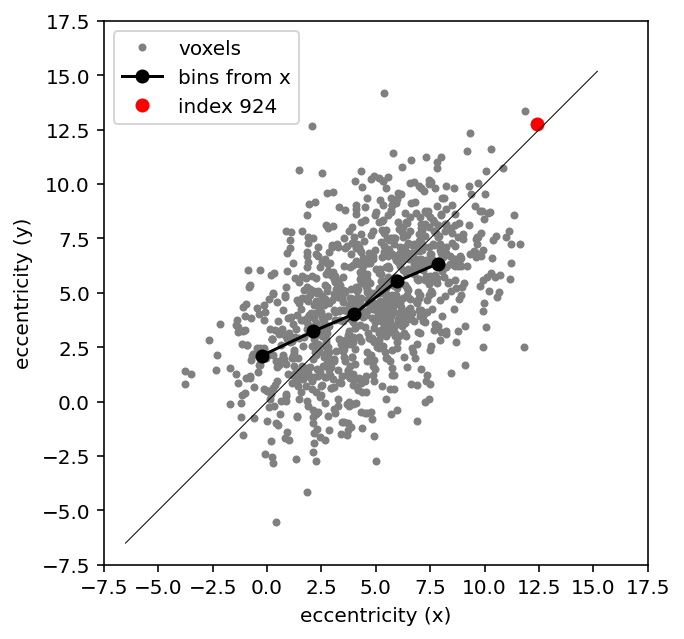

In [3]:
# form bins using x
bins = np.arange(min_ecc, max_ecc+2, 2)
ecc_x_digitized = np.digitize(ecc_x, bins)
# and bin both x and y using those x bins
ecc_x_xbinned, ecc_y_xbinned = [[this_var[ecc_x_digitized == i].mean() for i in range(len(bins))]
                      for this_var in (ecc_x,ecc_y)]
make_plot(ecc_x, ecc_y, ecc_x_xbinned, ecc_y_xbinned, 'bins from x', highlight=np.argmax(ecc_x))

Notice how even though the pRFs for x and y come from the same distribution, the binned eccentricity estimates have a *flatter* slope than the unity line. The eccentricity bins are further apart in the bin-defining x data than they are in the independent y data. So if you were to compare the binned data in the two contexts x,y, you would be almost guaranteed to find artefactual differences. And that's regression to the mean.

To understand this a bit better, let's focus on the example pRF highlighted in red above. It's the biggest eccentricity estimate in the x data at around 12.5, but in the y data it's around 8. Regression to the mean again. What's happening is that by selecting an extreme in a noisy dataset we end up with a case where we were 'lucky' with the noise - it pushed the estimate up instead of down. In the independent y split we are unlikely to be so lucky again. 

Much the same thing is going on in the bins - the bins toward the extremes are made up of not just pRFs with small or large ground-truth eccentricities, but also pRFs with noise that happened to push them in the 'right' direction such that they ended up in an extreme bin. And that doesn't happen again in the independent y context, so the bin average drops a bit.

The situation is very similar to how [effect size estimates are inflated by significance-filtering, as I discussed in another post](https://www.johancarlin.com/the-curse-of-low-statistical-power.html).

## Possible solutions
If you really must bin your data, it's better to do so in a way that includes all the data you'll be working with. For instance, we could just form an average over xy, and get our bin indices from that

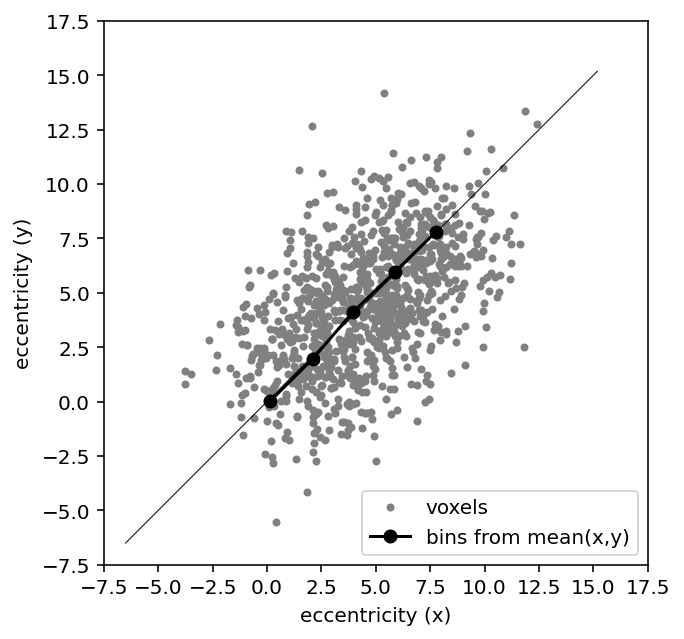

In [4]:
ecc_xy = np.array((ecc_x, ecc_y)).mean(axis=0)
ecc_xy_digitized = np.digitize(ecc_xy, bins)
ecc_x_xybinned, ecc_y_xybinned = [[this_var[ecc_xy_digitized == i].mean() for i in range(len(bins))]
                      for this_var in (ecc_x,ecc_y)]
make_plot(ecc_x, ecc_y, ecc_x_xybinned, ecc_y_xybinned, 'bins from mean(x,y)')

Now the bins line up nicely with the unity line, as they should in this simulated null case.

Another way to go would be to use a third, independent context to form the bins, as the [blog post](https://neuroneurotic.net/2020/10/29/when-the-hole-changes-the-pigeon/) I mentioned earlier discusses. This is expensive (you waste data on just defining bins), and is going to produce more variable estimates if the bin-defining part of the dataset is smaller. But it might be an attractive option for instance if you want to have valid errors on the bin estimates above for single-participant inferences (at the moment we underestimate this because the bin edges effectively cap the variability within each bin). You can often circumvent this issue by taking the estimates up to a second-level group analysis instead.
## Wait, is this basically circular analysis?
It's similar, but not quite the same. Classic circular analysis as discussed by [Kriegeskorte et al. (2009)](https://doi.org/10.1038/nn.2303) is about re-using the same exact data. For instance, focusing only on the x context, circular analysis would be fit a slope to the eccentricity data after binning. The bins already used the same data, so you are guaranteed to find a positive slope. By conditioning on the same data that you are then testing your hypothesis on, you obtain spuriously low variability in your estimates.

In a way, regression to the mean is the *opposite* effect. By conditioning on one noisy context you overestimate any *differences* between that context and another.

The subtle thing here is that we are using *some* independent data, which might tempt us to think that there is no circularity, and therefore everything is fine. But that's only true for some questions we might ask of the data.


## How do I avoid this?
* Don't run statistics on pooled data if you can help it. It can be tempting to 'clean' noisy data by pooling, but this is rarely necessary for statistical tests. For example, you could use [Deming regression](https://en.wikipedia.org/wiki/Deming_regression) to estimate how pRFs change with the x,y context (standard OLS regression would be a bad idea because you have errors in both variables).
* If you're going to clean up visualisations by pooling or plotting fitted values, plot the raw data underneath. My statistical spidey sense tingles whenever I see plots of highly derived statistics without the data. If the data are truly too noisy and dense to be any use, [percentiles tend to be more helpful than parametric standard errors or CIs](https://twitter.com/johancarlin/status/1296778033387507716?s=20).
* Simulate your data, and run the exact same code you use for the real data on the fake data. For instance, here is a recent paper on this for pRF models ([Lerma-Usabiaga et al., 2020](https://doi.org/10.1371/journal.pcbi.1007924)). Simulating the data generating process may sound challenging, but it really depends on what you're testing - as we saw here, you can get far with a Gaussian random number generator. Even if your data-generating simulation is embarrassingly crude (my attempts certainly are), the results often surprise. [Our latest preprint](https://doi.org/10.1101/2020.11.20.392258) is basically just this approach applied to layer fMRI analysis methods, and finding that some of these methods don't really work as advertised. Numerical simulations may seem an unprincipled approach, but statisticians like [Andrew Gelman](https://statmodeling.stat.columbia.edu/2019/03/23/yes-i-really-really-really-like-fake-data-simulation-and-i-cant-stop-talking-about-it/) swear by it. 

## Thanks
[Kendrick Kay](http://cvnlab.net/) and [Sam Schwarzkopf](https://sampendu.net/sam-schwarzkopf/) provided helpful comments on this post.